# R as Geographic Information system

With the right packages R is a powerful and simple to use GIS.
Let us process our classified raster obtained from SatEx.

First we tell R the correct path and load some packages we will need

In [1]:
setwd("/home/sysop/Desktop/RS_Data/Lima")

library("sp")
library("rgdal")
library("raster")


rgdal: version: 1.2-7, (SVN revision 660)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 1.11.3, released 2015/09/16
 Path to GDAL shared files: /usr/share/gdal/1.11
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-4 


## Load rasters

We can load raster files in using the raster package. We load both classified scenes and plot them.

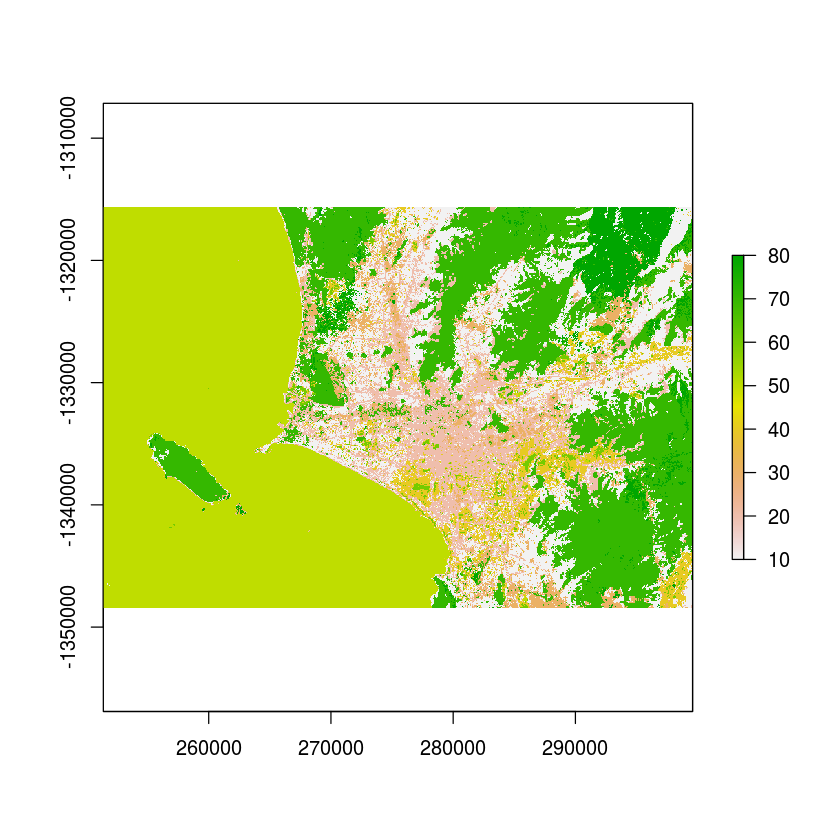

In [2]:
L8 <- raster("classes.tif")
plot(L8)

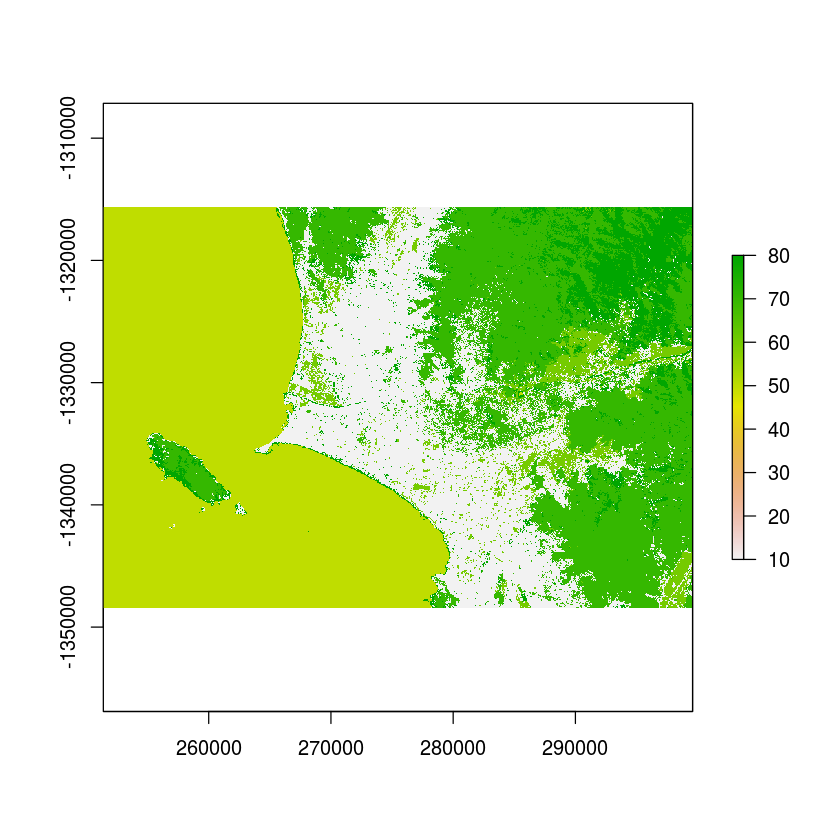

In [3]:
L5 <- raster("classes_L5.tif")
plot(L5)

Taking a look at the created object, we can also check details of the raster like projection resolution etc.

In [4]:
L5
L8

class       : RasterLayer 
dimensions  : 1095, 1607, 1759665  (nrow, ncol, ncell)
resolution  : 29.99883, 29.99249  (x, y)
extent      : 251378, 299586.1, -1348447, -1315605  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=utm +zone=18 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 
data source : /home/sysop/Desktop/RS_Data/Lima/classes_L5.tif 
names       : classes_L5 
values      : 10, 80  (min, max)


class       : RasterLayer 
dimensions  : 1095, 1607, 1759665  (nrow, ncol, ncell)
resolution  : 29.99883, 29.99249  (x, y)
extent      : 251378, 299586.1, -1348447, -1315605  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=utm +zone=18 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 
data source : /home/sysop/Desktop/RS_Data/Lima/classes.tif 
names       : classes 
values      : 10, 70  (min, max)


## Resampling and masking
In the next step we make sure the rasters match precisely and resample the L5 classification on the L8 classification.l
Afterwards we create a built-up mask (binary 1,0 raster) from the L8 classification.

In [5]:
L5 <- resample(L5,L8,method='ngb')

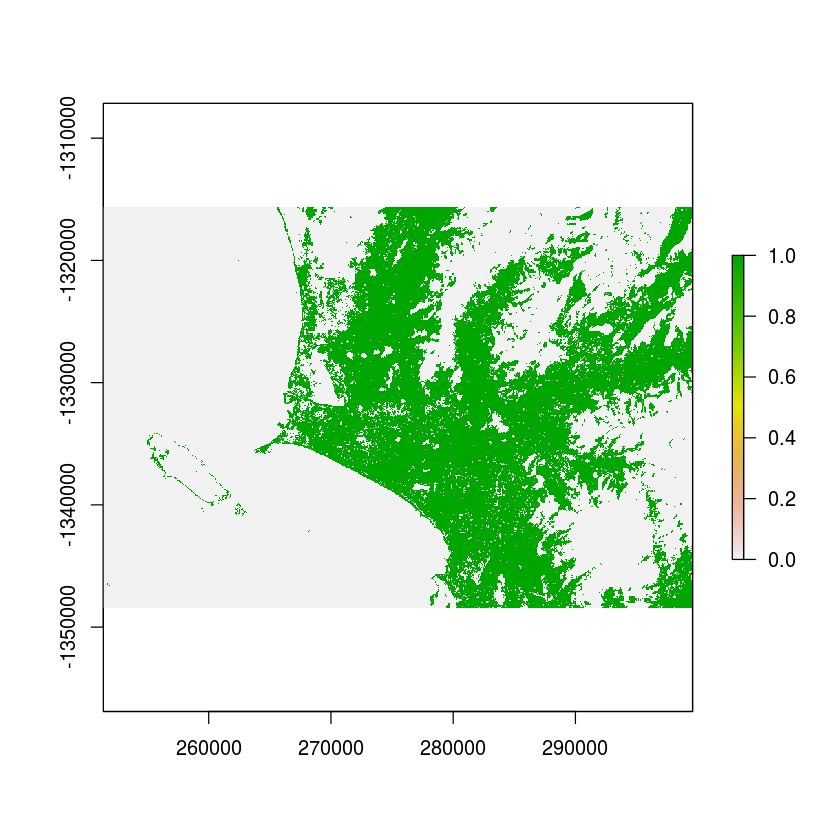

In [6]:
mask <- L8
rcl <- c(10,40,1,50,90,0)
rclMat <- matrix(rcl,ncol=3,byrow=T)
mask <- reclassify(mask,rclMat,right=NA)
plot(mask)

We can create an age class **reclassifying** our rasters and then **masking** them.
Finally, we can build a **differential** between the two time steps.

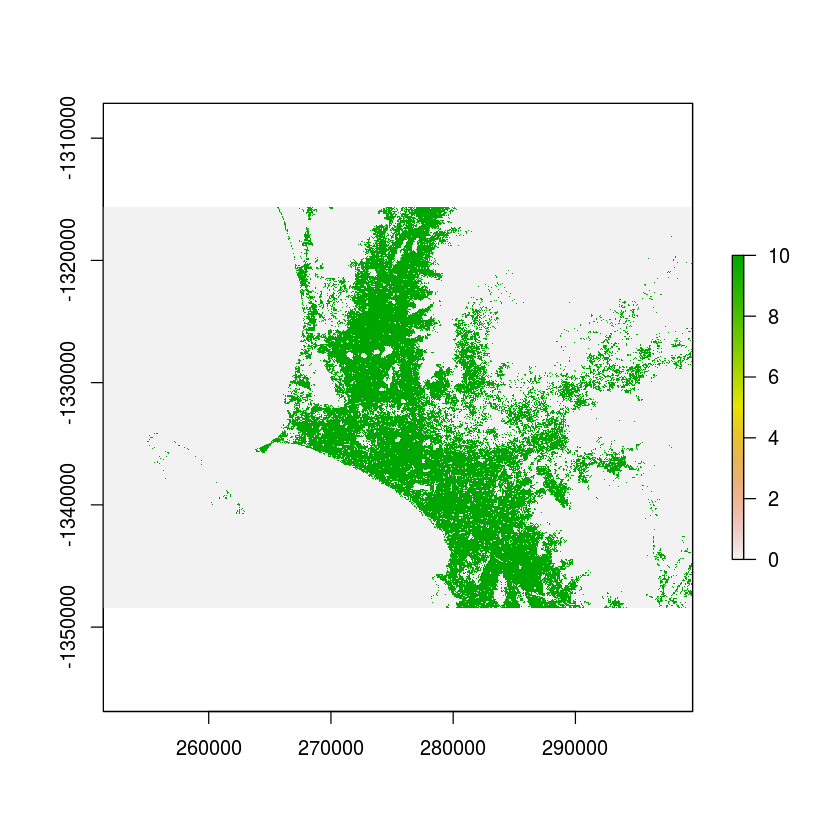

In [7]:
#Mask the older scene
bu_old <- L5
rcl <- c(10,10,10,40,90,0)
rclMat <- matrix(rcl,ncol=3,byrow=T)
bu_old <- reclassify(L5,rclMat,right=NA)
bu_old <- bu_old*mask
plot(bu_old)

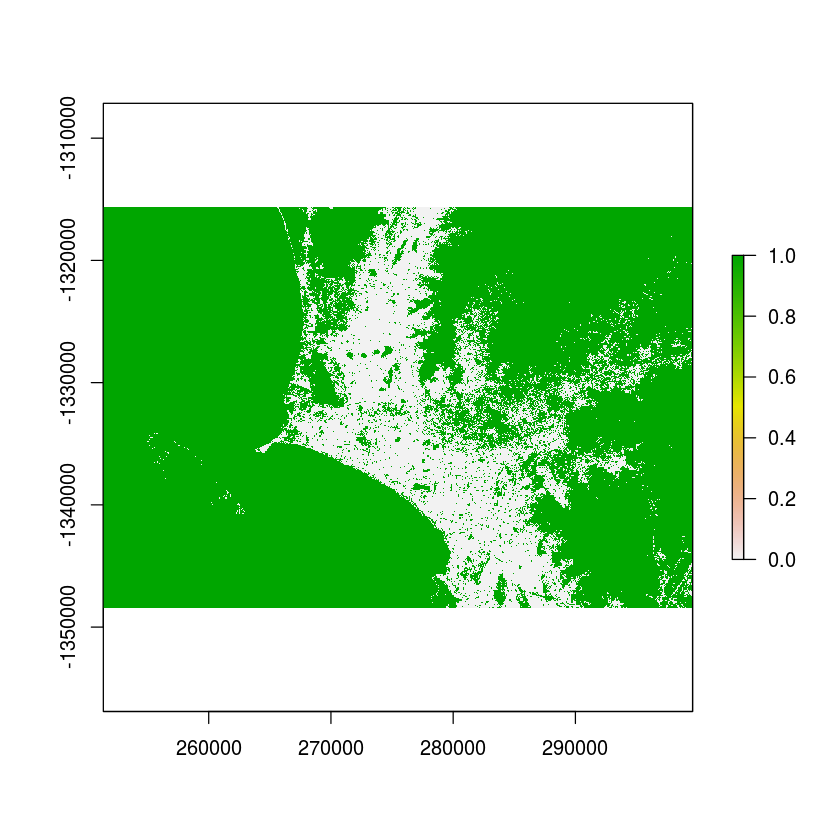

In [9]:
#mask for old built-up regions
mask_old <- bu_old
rcl <- c(0,0,1,10,10,0)
rclMat <- matrix(rcl,ncol=3,byrow=T)
mask_old <- reclassify(mask_old,rclMat,right=NA)
plot(mask_old)

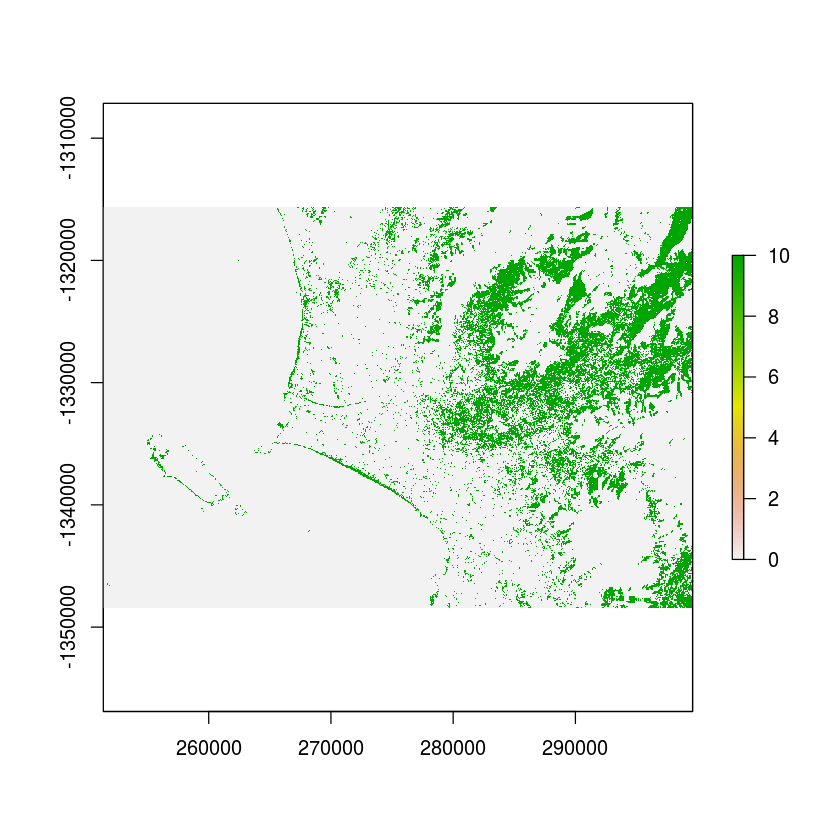

In [10]:
#Reclassify all built up classes two 10
bu_new <- L8 
rcl <- c(10,40,10,50,90,0)
rclMat <- matrix(rcl,ncol=3,byrow=T)
bu_new <- reclassify(bu_new,rclMat,right=NA)
age_new <- bu_new*mask_old
plot(age_new)

Reclassifying the scene. Our suggestion is to use e.g., a two digit number to build new classes:
* The number component of order 10 is for age 
* and the number of order 1 is for the landuse class.

For example: 
* 1x $\rightarrow$ built before 1990
* 2x $\rightarrow$ built after 1990
* x1 $\rightarrow$ residential
* x2 $\rightarrow$ mixed

etc.

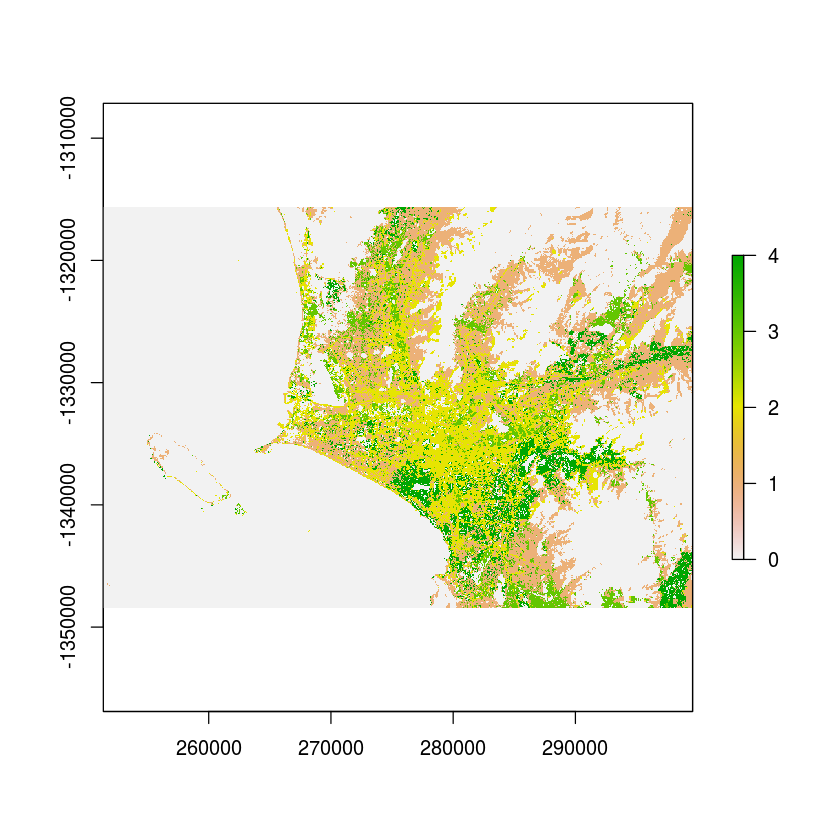

In [12]:
#reclassify the 2016 built up layer 10,20,30,40 -> 1,2,3,4 for types
landuse <- L8
rcl <- c(10,10,1,20,20,2,30,30,3,40,40,4,50,90,0)
rclMat <- matrix(rcl,ncol=3,byrow=T)
landuse <- reclassify(landuse,rclMat,right=NA)
plot(landuse)

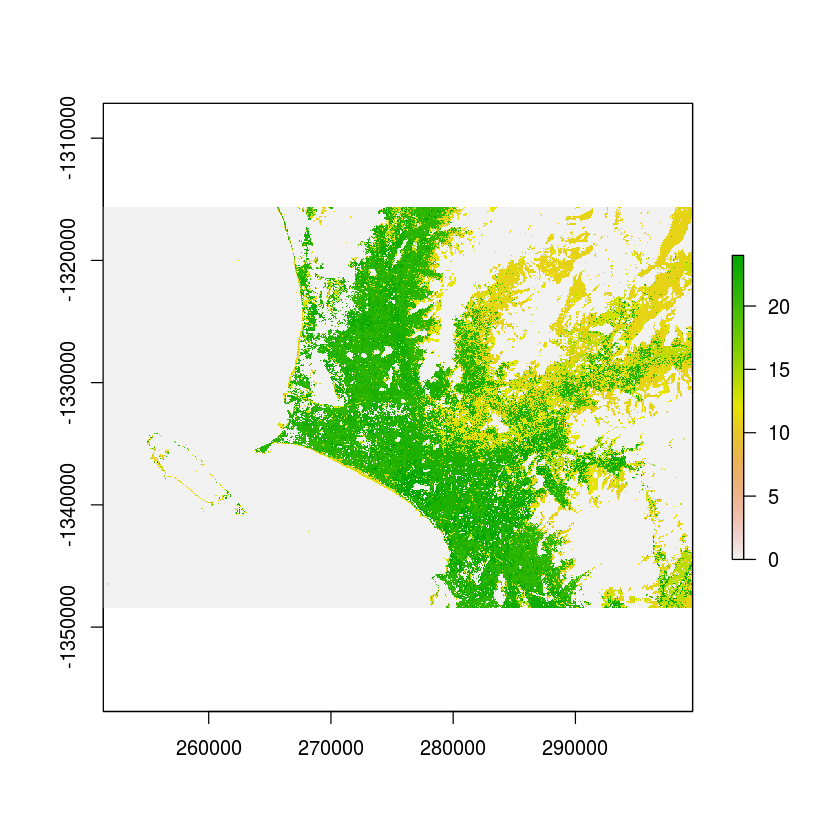

In [13]:
#create sum of all layers
simpleTypes <- bu_old+bu_new+landuse
plot(simpleTypes)

### Export the file to import for example in QGIS

Save as a raster file

In [14]:
#reclassify 0 to NA
rcl <- c(0,0,NA)
rclMat <- matrix(rcl,ncol=3,byrow=T)
simpleTypes <- reclassify(simpleTypes,rclMat,right=NA)

#write types to file
writeRaster(simpleTypes,filename='simple_types',format='GTiff',overwrite=T,NAflag=0)